In [2]:
from nn.models import C6_4l_clf, swish_activation
from nn import datasets
from hstar import process, trilinear
from hzz import zcandidate, angles

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

2024-11-12 23:36:36.520293: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 23:36:36.583384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731450996.605328  112520 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731450996.611869  112520 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 23:36:36.635951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
sample = process.Sample(weight='wt', 
    amplitude = process.Basis.SBI, components = {
    process.Basis.SBI: 'msq_sbi_sm',
    process.Basis.SIG: 'msq_sig_sm',
    process.Basis.BKG: 'msq_bkg_sm',
    process.Basis.INT: 'msq_int_sm'
  })

sample.open(csv = [
  '../ggZZ4e_all_new.csv',
  '../ggZZ4m_all_new.csv',
  '../ggZZ2e2m_all_new.csv'
  ], xs=[1.4783394, 0.47412769, 0.47412769], lumi=3000., k=1.83, nrows=1200000
)

sample.events = sample.events.sample(frac=1).reset_index(drop=True).iloc[3000000:]

print(sample.events.shape)

zmasses = zcandidate.ZmassPairChooser(sample)
leptons = zmasses.find_Z()

print(sample.events.shape)

kin_variables, filter_indices = angles.calculate(leptons.T[0], leptons.T[1], leptons.T[2], leptons.T[3])

kin_variables = kin_variables[filter_indices]
sample.events = sample.events.take(indices=filter_indices)

print(sample.events.shape)

c6_values = [10]

c6_mod = trilinear.Modifier(c6_values = [-5,-1,0,1,5], c6_amplitudes = ['msq_sbi_c6_6', 'msq_sbi_c6_10', 'msq_sbi_c6_11', 'msq_sbi_c6_12', 'msq_sbi_c6_16'])
c6_weights = c6_mod.modify(sample=sample, c6=c6_values)

test_data = datasets.build_dataset_tf(x_arr = kin_variables,
                                      param_values = c6_values,
                                      signal_weights = c6_weights,
                                      background_weights = tf.convert_to_tensor(sample.events['wt']), 
                                      normalization = 1)

0          6.917264e-12
1          4.352699e-10
2          1.308438e-09
3          1.289731e-09
4          1.347206e-13
               ...     
1199995    4.149453e-09
1199996    3.268040e-09
1199997    5.843582e-09
1199998    3.206703e-10
1199999    7.858440e-10
Name: msq_sbi_sm, Length: 3600000, dtype: float64
0          7.188681e-14
1          3.480814e-11
2          1.946946e-11
3          1.735510e-11
4          6.937648e-15
               ...     
1199995    2.349468e-11
1199996    1.260399e-10
1199997    3.164702e-10
1199998    9.147576e-13
1199999    8.251521e-11
Name: msq_sig_sm, Length: 3600000, dtype: float64
0          7.326896e-12
1          4.924589e-10
2          1.370247e-09
3          1.360140e-09
4          1.353118e-13
               ...     
1199995    4.199106e-09
1199996    3.261307e-09
1199997    6.262901e-09
1199998    3.239311e-10
1199999    8.975898e-10
Name: msq_bkg_sm, Length: 3600000, dtype: float64
0         -4.813898e-13
1         -9.161464e-11
2         

2024-11-12 23:38:09.295179: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Non param


In [4]:
print(test_data, test_data.shape)

tf.Tensor(
[[-9.9773675e-01  9.9993593e-01  9.9999934e-01 ...  3.3266888e+02
   1.0000000e+00  3.0763103e-06]
 [ 9.9174261e-01  9.8957753e-01  7.2186545e-02 ...  2.2507329e+02
   1.0000000e+00  1.4631959e-06]
 [-7.2035348e-01 -2.7838591e-01  8.7716931e-01 ...  2.1840054e+02
   1.0000000e+00  5.8738360e-06]
 ...
 [-9.9637473e-01  9.9980950e-01  9.9591219e-01 ...  2.6967020e+02
   0.0000000e+00  1.9803647e-06]
 [-7.6371169e-01  7.9851723e-01  9.0084726e-01 ...  2.0833296e+02
   0.0000000e+00  7.4615394e-07]
 [ 5.9107059e-01  4.6221656e-01 -5.6536174e-01 ...  4.1708725e+02
   0.0000000e+00  7.9577092e-07]], shape=(1139260, 10), dtype=float32) (1139260, 10)


In [5]:
model = keras.models.load_model('outputs_single/ckpt/checkpoint.model_1.keras', custom_objects={'C6_4l_clf_reduced_nonprm': C6_4l_clf, 'swish_activation': swish_activation})

/u/griesemx/git/bsc-thesis/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
predictions = []
real_ratios = []

arr_len = test_data.shape[0]/len(c6_values)

for i in range(len(c6_values)):
    c6 = c6_values[i]
    data = test_data[int(i*arr_len):int((i+0.5)*arr_len),:8]
    pred = model.predict(data)
    predictions.append(pred)

    real_ratio = test_data[int(i*arr_len):int((i+0.5)*arr_len),9]/test_data[int((i+0.5)*arr_len):int((i+1)*arr_len),9]
    real_ratios.append(real_ratio)

predictions = tf.convert_to_tensor(predictions)

ratios = tf.squeeze(predictions/(1-predictions), axis=2)

print(ratios)

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios)

I0000 00:00:1731451090.652688  137463 service.cc:148] XLA service 0x1536142c8230 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731451090.652782  137463 service.cc:156]   StreamExecutor device (0): Host, Default Version
2024-11-12 23:38:10.668656: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


   53/17801 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step  

I0000 00:00:1731451091.684249  137463 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17801/17801 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step
tf.Tensor([[0.99969894 0.99969894 0.99969894 ... 0.99969894 0.99969894 0.99969894]], shape=(1, 569630), dtype=float32)
tf.Tensor([[0.9997532 0.9961652 0.9938861 ... 1.0034897 0.9998184 0.9889058]], shape=(1, 569630), dtype=float32)


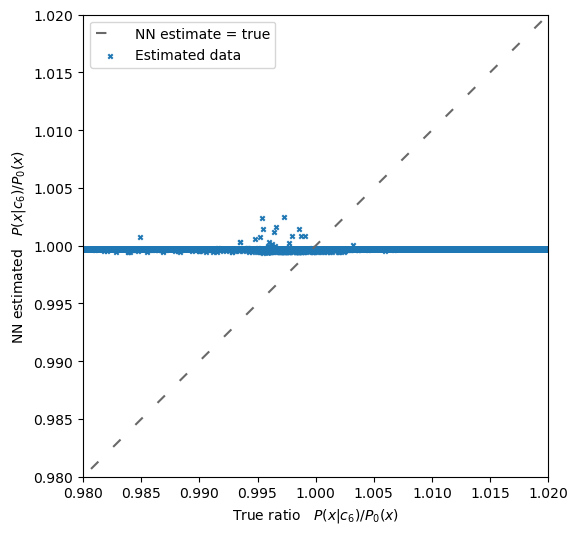

In [20]:
real = real_ratios.numpy()
pred = ratios.numpy()

lnspc = np.linspace(0.6,1.2)

plt.figure(figsize=(6,6))

plt.plot(lnspc, lnspc, color='dimgray', linestyle=(0,(5,10)), label='NN estimate = true')
plt.scatter(real, pred, s=10, marker='x', label='Estimated data')
plt.xlabel(u'True ratio   $P(x|c_6)/P_0(x)$')
plt.ylabel(u'NN estimated   $P(x|c_6)/P_0(x)$')
plt.xlim(0.6,1.2)
plt.ylim(0.6,1.2)
plt.legend()



In [10]:
hist_prm = ''

with open(f'outputs_single/history/history_1.txt', 'r') as hist_file:
    hist_prm = hist_file.readlines()

hist_prm = [ np.array(el.replace('[','').replace(']','').replace(' ','').split(','), dtype=float) for el in hist_prm[0].split('][')]

t_loss_prm = np.array(hist_prm[0])
v_loss_prm = np.array(hist_prm[1])

epochs = range(1,101)

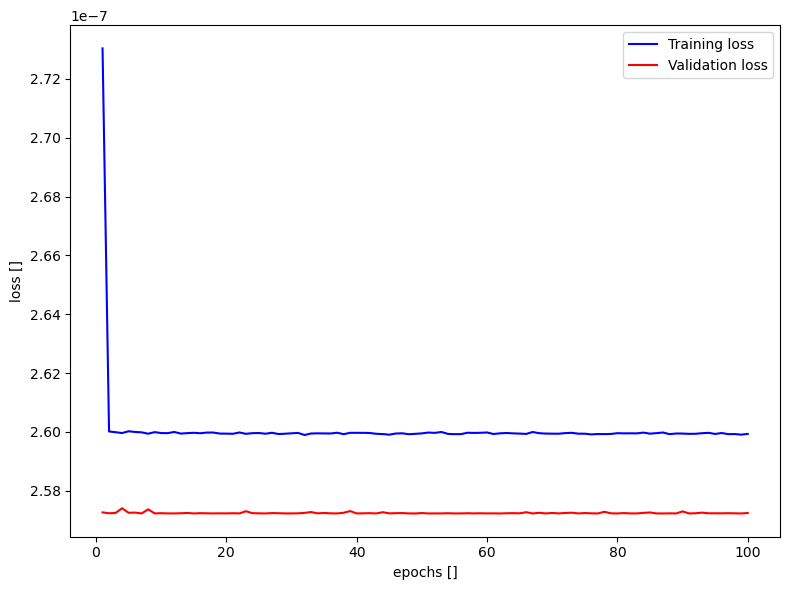

In [11]:
fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss_prm, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel('loss []')
#ax2.legend()

plt.plot(epochs, v_loss_prm, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()